In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from esda.moran import Moran
from libpysal.weights import W

In [3]:
def smooth_prevalence(sim_df, tract_id, h):
    sim_df_sub = sim_df.loc[sim_df['geoid_i'] == tract_id]
    nb_val = sim_df_sub['prev_m'].to_numpy()
    nb_dist = sim_df_sub['S_im'].to_numpy()
    neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2))) 
    centroid_smoothed_val = round(sum(nb_val * neighbor_weight), 4)
    if centroid_smoothed_val is None:
        print(sim_df_sub)
        print(nb_val)
        print(nb_dist)
    return centroid_smoothed_val

In [4]:
def smooth_given_h(h, sim_df):
    i_tracts = sim_df['geoid_i'].unique()
    i_smoothed = []
    for i in range(len(i_tracts)):
        re = smooth_prevalence(sim_df, i_tracts[i], h)
        i_smoothed.append(re)
    return i_smoothed


In [5]:
def smooth_given_h_dataframe(h, sim_df):
    smoothed_1 = pd.DataFrame()
    smoothed_1['tract_id'] = sim_df['geoid_i'].unique()
    smoothed_1['Pih_5_m'] = smooth_given_h(h, sim_df)
    smoothed_1.columns = ['geoid_i', 'Pih_5_i']
    smoothed_m = smoothed_1.copy()
    smoothed_m.columns= ['geoid_m', 'Pih_5_m']
    sim_df2 = sim_df.merge(smoothed_1, how='left', on ='geoid_i')
    sim_df2 = sim_df2.merge(smoothed_m, how='left', on ='geoid_m')
    sim_df2 = sim_df2.fillna(0)   
    return sim_df2

In [6]:
def get_Moran_I(df, h):
    sim_sp = smooth_given_h_dataframe(h, df)
    sim_sp = sim_sp[['geoid_i', 'geoid_m', 'Pih_5_i', 'Pih_5_m', 'S_im']]

    geoid = pd.DataFrame(sim_sp['geoid_i'].unique(), columns=['geoid_i']).reset_index()
    geoid.columns = ['int_i', 'geoid_i']

    sim_sp = sim_sp.merge(geoid, how='left', on='geoid_i')

    geoid_2 = geoid.copy()
    geoid_2.columns = ['int_m', 'geoid_m']

    #geoid that are not urban but appeared in neighbour columns
    other_geoid = list(set(sim_sp['geoid_m']) - set(sim_sp['geoid_i']))
    other_df = pd.DataFrame(other_geoid, columns=['geoid_m']).reset_index()
    other_df.columns=['int_m', 'geoid_m']
    start = max(sim_sp['int_i']) + 1
    end = start + len(other_df) 
    other_df['int_m'] = list(range(start, end, 1))
    geoid_2 = pd.concat([geoid_2, other_df])

    sim_sp = sim_sp.merge(geoid_2, how='left', on='geoid_m')

    sim_sp['S_im_alpha'] = sim_sp['S_im'].apply(lambda x: round(1/x, 4))

    sim_sp_test = sim_sp[['Pih_5_i', 'Pih_5_m', 'S_im', 'int_i', 'int_m', 'S_im_alpha']]


    sim_sp_test_fake = sim_sp_test.loc[sim_sp_test['int_m'] > max(sim_sp['int_i'])]
    sim_sp_test_fake = sim_sp_test_fake.rename(columns = {'Pih_5_i': 'Pih_5_m', 
                                                        'Pih_5_m': 'Pih_5_i', 
                                                        'int_i': 'int_m', 
                                                        'int_m': 'int_i'})

    sim_sp_test_fake = sim_sp_test_fake[['Pih_5_i', 'Pih_5_m', 'S_im', 'int_i', 'int_m', 'S_im_alpha']]


    sim_sp_test = pd.concat([sim_sp_test, sim_sp_test_fake])
    sim_sp_test = sim_sp_test.sort_values(by=['int_i', 'int_m'])
    sim_sp_test.replace([np.inf, -np.inf], 0, inplace=True)

    nbs = sim_sp_test.groupby('int_i')['int_m'].apply(lambda x: x.tolist()).to_dict()
    weights = sim_sp_test.groupby('int_i')['S_im_alpha'].apply(lambda x: x.tolist()).to_dict()
    w = W(nbs, weights)
    y = sim_sp_test[['int_i', 'Pih_5_i']].drop_duplicates()
    moran = Moran(y['Pih_5_i'].values, w)
    spatial_correlation = moran.I
    return spatial_correlation

In [7]:

sim_tp = {'mi_to_tract': 'float64', 'state': 'int64', 'geoid_i': 'object', 'geoid_m': 'object', 'ruca_i': 'int64', 'ruca_m': 'int64', 'rank': 'float64', 'cat_i': 'object', 'pov_child_pct_i': 'float64', 'pov_child_pct_m': 'float64', 'R_im': 'int64', 'D_im': 'int64', 'D_im_prob': 'float64', 'pov_diff': 'float64', 'P_im': 'int64', 'P_im_prob': 'float64', 'S_im': 'float64'}
tp = {'state_cd': 'object', 'tract_id': 'object', 'outcome1_prevalence_tract': 'float64'}

fips_dict = {'AK': 2, 'AL': 1,  'AZ': 4, 'CA': 6, 'CO': 8,  'DC': 11, 'DE': 10, 'FL': 12, 'GA': 13,  'HI': 15, 'IA': 19, 'ID': 16, 'IL': 17, 'IN': 18, 'KS': 20, 'KY': 21, 'LA': 22, 'MA': 25, 'MD': 24, 'ME': 23, 'MI': 26, 'MN': 27, 'MO': 29, 'MS': 28, 'MT': 30, 'NC': 37, 'ND': 38,  'NH': 33, 'NM': 35,  'NY': 36, 'OH': 39, 'OK': 40, 'OR': 41, 'PA': 42, 'PR': 72, 'RI': 44, 'SC': 45, 'SD': 46, 'TN': 47, 'TX': 48, 'UT': 49, 'VA': 51,  'WA': 53, 'WI': 55, 'WV': 54}


In [8]:

c_path = '/Users/mercuryliu/Documents/MH Research/MH prevalence/VM exported data/07082022 w 11/'
figpath='/Users/mercuryliu/Documents/MH Research/MH prevalence/results/'

In [35]:
all_st = ['NY', 'WA', 'VA', 'AL', 'AZ', 'GA', 'LA', 'MA', 'MI', 'MS', 'NC', 'SC', 'TX', 'OH']


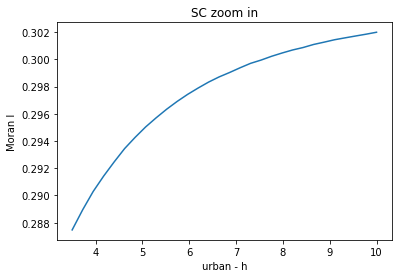

In [15]:

curr_state = 'SC'
curr_st_key = fips_dict.get(curr_state)

sim = pd.read_csv('/Users/mercuryliu/Documents/MH Research/MH prevalence/Census tract data/Tract_to_ruca/urban_processed.csv', dtype=sim_tp)
sim = sim.loc[sim['state'] == curr_st_key]

prev =  pd.read_csv(c_path + 'ot_tract_' + curr_state + '.csv', dtype=tp)
prev_i = prev.copy()
prev_i.columns = ['state_cd', 'geoid_i', 'prev_i']
prev_m = prev.copy()
prev_m.columns = ['state_cd', 'geoid_m', 'prev_m']

sim = sim.merge(prev_i, how='inner', on='geoid_i')
sim = sim.merge(prev_m, how='left', on='geoid_m')

sim = sim.drop(columns=['state_cd_y'], axis=1)
sim = sim.fillna(0)


#h_list = np.linspace(0, 4, num=30)
h_list = np.linspace(3.5, 10, num=30)

moran_I = []
for j in range(len(h_list)):
    moran_I.append(get_Moran_I(sim, h_list[j] ))


plt.plot(h_list, moran_I, label='urban')
plt.title(curr_state + ' zoom in')
plt.ylabel('Moran I')
plt.xlabel('urban - h')
plt.savefig(figpath + curr_state + 'urban_h.png')

plt.show()


<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: divide by zero encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: invalid value encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:226: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:201: RuntimeWarning: invalid value encountered in true_divide
  self.z /= sy
<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: invalid value encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.

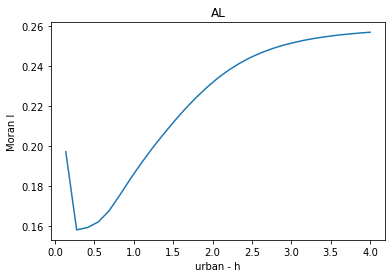

In [37]:

curr_state = all_st[3]
curr_st_key = fips_dict.get(curr_state)

sim = pd.read_csv('/Users/mercuryliu/Documents/MH Research/MH prevalence/Census tract data/Tract_to_ruca/urban_processed.csv', dtype=sim_tp)
sim = sim.loc[sim['state'] == curr_st_key]

prev =  pd.read_csv(c_path + 'ot_tract_' + curr_state + '.csv', dtype=tp)
prev_i = prev.copy()
prev_i.columns = ['state_cd', 'geoid_i', 'prev_i']
prev_m = prev.copy()
prev_m.columns = ['state_cd', 'geoid_m', 'prev_m']

sim = sim.merge(prev_i, how='inner', on='geoid_i')
sim = sim.merge(prev_m, how='left', on='geoid_m')

sim = sim.drop(columns=['state_cd_y'], axis=1)
sim = sim.fillna(0)


h_list = np.linspace(0, 4, num=30)
moran_I = []
for j in range(len(h_list)):
    moran_I.append(get_Moran_I(sim, h_list[j] ))


plt.plot(h_list, moran_I, label='urban')
plt.title(curr_state)
plt.ylabel('Moran I')
plt.xlabel('urban - h')
plt.savefig(figpath + curr_state + 'urban_h.png')

#plt.show()


<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: divide by zero encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: invalid value encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:226: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:201: RuntimeWarning: invalid value encoun

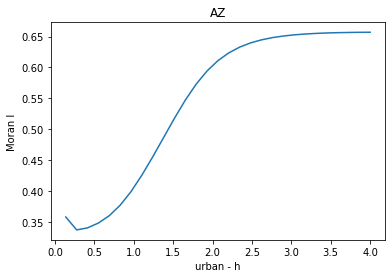

In [38]:

curr_state = all_st[4]
curr_st_key = fips_dict.get(curr_state)

sim = pd.read_csv('/Users/mercuryliu/Documents/MH Research/MH prevalence/Census tract data/Tract_to_ruca/urban_processed.csv', dtype=sim_tp)
sim = sim.loc[sim['state'] == curr_st_key]

prev =  pd.read_csv(c_path + 'ot_tract_' + curr_state + '.csv', dtype=tp)
prev_i = prev.copy()
prev_i.columns = ['state_cd', 'geoid_i', 'prev_i']
prev_m = prev.copy()
prev_m.columns = ['state_cd', 'geoid_m', 'prev_m']

sim = sim.merge(prev_i, how='inner', on='geoid_i')
sim = sim.merge(prev_m, how='left', on='geoid_m')

sim = sim.drop(columns=['state_cd_y'], axis=1)
sim = sim.fillna(0)


h_list = np.linspace(0, 4, num=30)
moran_I = []
for j in range(len(h_list)):
    moran_I.append(get_Moran_I(sim, h_list[j] ))


plt.plot(h_list, moran_I, label='urban')
plt.title(curr_state)
plt.ylabel('Moran I')
plt.xlabel('urban - h')
plt.savefig(figpath + curr_state + 'urban_h.png')

#plt.show()


<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: divide by zero encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: invalid value encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:226: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:201: RuntimeWarning: invalid value encountered in true_divide
  self.z /= sy
<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: invalid value encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.

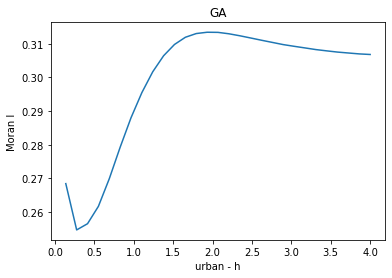

In [39]:

curr_state = all_st[5]
curr_st_key = fips_dict.get(curr_state)

sim = pd.read_csv('/Users/mercuryliu/Documents/MH Research/MH prevalence/Census tract data/Tract_to_ruca/urban_processed.csv', dtype=sim_tp)
sim = sim.loc[sim['state'] == curr_st_key]

prev =  pd.read_csv(c_path + 'ot_tract_' + curr_state + '.csv', dtype=tp)
prev_i = prev.copy()
prev_i.columns = ['state_cd', 'geoid_i', 'prev_i']
prev_m = prev.copy()
prev_m.columns = ['state_cd', 'geoid_m', 'prev_m']

sim = sim.merge(prev_i, how='inner', on='geoid_i')
sim = sim.merge(prev_m, how='left', on='geoid_m')

sim = sim.drop(columns=['state_cd_y'], axis=1)
sim = sim.fillna(0)


h_list = np.linspace(0, 4, num=30)
moran_I = []
for j in range(len(h_list)):
    moran_I.append(get_Moran_I(sim, h_list[j] ))


plt.plot(h_list, moran_I, label='urban')
plt.title(curr_state)
plt.ylabel('Moran I')
plt.xlabel('urban - h')
plt.savefig(figpath + curr_state + 'urban_h.png')

#plt.show()


<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: divide by zero encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: invalid value encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:226: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:201: RuntimeWarning: invalid value encoun

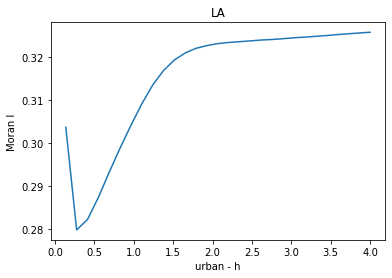

In [40]:

curr_state = all_st[6]
curr_st_key = fips_dict.get(curr_state)

sim = pd.read_csv('/Users/mercuryliu/Documents/MH Research/MH prevalence/Census tract data/Tract_to_ruca/urban_processed.csv', dtype=sim_tp)
sim = sim.loc[sim['state'] == curr_st_key]

prev =  pd.read_csv(c_path + 'ot_tract_' + curr_state + '.csv', dtype=tp)
prev_i = prev.copy()
prev_i.columns = ['state_cd', 'geoid_i', 'prev_i']
prev_m = prev.copy()
prev_m.columns = ['state_cd', 'geoid_m', 'prev_m']

sim = sim.merge(prev_i, how='inner', on='geoid_i')
sim = sim.merge(prev_m, how='left', on='geoid_m')

sim = sim.drop(columns=['state_cd_y'], axis=1)
sim = sim.fillna(0)


h_list = np.linspace(0, 4, num=30)
moran_I = []
for j in range(len(h_list)):
    moran_I.append(get_Moran_I(sim, h_list[j] ))


plt.plot(h_list, moran_I, label='urban')
plt.title(curr_state)
plt.ylabel('Moran I')
plt.xlabel('urban - h')
plt.savefig(figpath + curr_state + 'urban_h.png')

#plt.show()


<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: divide by zero encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: invalid value encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:226: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:201: RuntimeWarning: invalid value encountered in true_divide
  self.z /= sy
<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: invalid value encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.

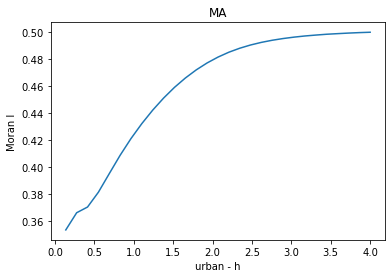

In [41]:

curr_state = all_st[7]
curr_st_key = fips_dict.get(curr_state)

sim = pd.read_csv('/Users/mercuryliu/Documents/MH Research/MH prevalence/Census tract data/Tract_to_ruca/urban_processed.csv', dtype=sim_tp)
sim = sim.loc[sim['state'] == curr_st_key]

prev =  pd.read_csv(c_path + 'ot_tract_' + curr_state + '.csv', dtype=tp)
prev_i = prev.copy()
prev_i.columns = ['state_cd', 'geoid_i', 'prev_i']
prev_m = prev.copy()
prev_m.columns = ['state_cd', 'geoid_m', 'prev_m']

sim = sim.merge(prev_i, how='inner', on='geoid_i')
sim = sim.merge(prev_m, how='left', on='geoid_m')

sim = sim.drop(columns=['state_cd_y'], axis=1)
sim = sim.fillna(0)


h_list = np.linspace(0, 4, num=30)
moran_I = []
for j in range(len(h_list)):
    moran_I.append(get_Moran_I(sim, h_list[j] ))


plt.plot(h_list, moran_I, label='urban')
plt.title(curr_state)
plt.ylabel('Moran I')
plt.xlabel('urban - h')
plt.savefig(figpath + curr_state + 'urban_h.png')

#plt.show()


<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: divide by zero encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: invalid value encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:226: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:201: RuntimeWarning: invalid value encoun

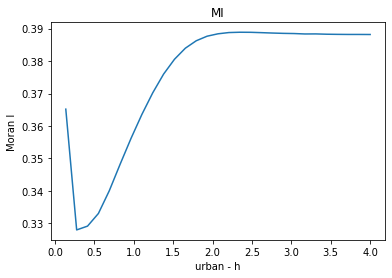

In [42]:

curr_state = all_st[8]
curr_st_key = fips_dict.get(curr_state)

sim = pd.read_csv('/Users/mercuryliu/Documents/MH Research/MH prevalence/Census tract data/Tract_to_ruca/urban_processed.csv', dtype=sim_tp)
sim = sim.loc[sim['state'] == curr_st_key]

prev =  pd.read_csv(c_path + 'ot_tract_' + curr_state + '.csv', dtype=tp)
prev_i = prev.copy()
prev_i.columns = ['state_cd', 'geoid_i', 'prev_i']
prev_m = prev.copy()
prev_m.columns = ['state_cd', 'geoid_m', 'prev_m']

sim = sim.merge(prev_i, how='inner', on='geoid_i')
sim = sim.merge(prev_m, how='left', on='geoid_m')

sim = sim.drop(columns=['state_cd_y'], axis=1)
sim = sim.fillna(0)


h_list = np.linspace(0, 4, num=30)
moran_I = []
for j in range(len(h_list)):
    moran_I.append(get_Moran_I(sim, h_list[j] ))


plt.plot(h_list, moran_I, label='urban')
plt.title(curr_state)
plt.ylabel('Moran I')
plt.xlabel('urban - h')
plt.savefig(figpath + curr_state + 'urban_h.png')

#plt.show()


<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: divide by zero encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: invalid value encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:226: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:201: RuntimeWarning: invalid value encoun

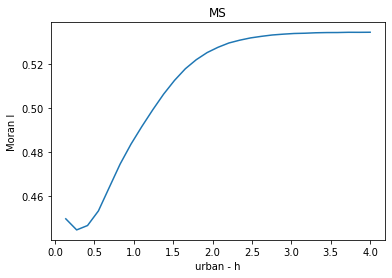

In [43]:

curr_state = all_st[9]
curr_st_key = fips_dict.get(curr_state)

sim = pd.read_csv('/Users/mercuryliu/Documents/MH Research/MH prevalence/Census tract data/Tract_to_ruca/urban_processed.csv', dtype=sim_tp)
sim = sim.loc[sim['state'] == curr_st_key]

prev =  pd.read_csv(c_path + 'ot_tract_' + curr_state + '.csv', dtype=tp)
prev_i = prev.copy()
prev_i.columns = ['state_cd', 'geoid_i', 'prev_i']
prev_m = prev.copy()
prev_m.columns = ['state_cd', 'geoid_m', 'prev_m']

sim = sim.merge(prev_i, how='inner', on='geoid_i')
sim = sim.merge(prev_m, how='left', on='geoid_m')

sim = sim.drop(columns=['state_cd_y'], axis=1)
sim = sim.fillna(0)


h_list = np.linspace(0, 4, num=30)
moran_I = []
for j in range(len(h_list)):
    moran_I.append(get_Moran_I(sim, h_list[j] ))


plt.plot(h_list, moran_I, label='urban')
plt.title(curr_state)
plt.ylabel('Moran I')
plt.xlabel('urban - h')
plt.savefig(figpath + curr_state + 'urban_h.png')

#plt.show()


<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: divide by zero encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: invalid value encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:226: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:201: RuntimeWarning: invalid value encoun

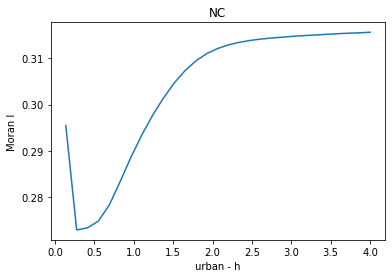

In [44]:

curr_state = all_st[10]
curr_st_key = fips_dict.get(curr_state)

sim = pd.read_csv('/Users/mercuryliu/Documents/MH Research/MH prevalence/Census tract data/Tract_to_ruca/urban_processed.csv', dtype=sim_tp)
sim = sim.loc[sim['state'] == curr_st_key]

prev =  pd.read_csv(c_path + 'ot_tract_' + curr_state + '.csv', dtype=tp)
prev_i = prev.copy()
prev_i.columns = ['state_cd', 'geoid_i', 'prev_i']
prev_m = prev.copy()
prev_m.columns = ['state_cd', 'geoid_m', 'prev_m']

sim = sim.merge(prev_i, how='inner', on='geoid_i')
sim = sim.merge(prev_m, how='left', on='geoid_m')

sim = sim.drop(columns=['state_cd_y'], axis=1)
sim = sim.fillna(0)


h_list = np.linspace(0, 4, num=30)
moran_I = []
for j in range(len(h_list)):
    moran_I.append(get_Moran_I(sim, h_list[j] ))


plt.plot(h_list, moran_I, label='urban')
plt.title(curr_state)
plt.ylabel('Moran I')
plt.xlabel('urban - h')
plt.savefig(figpath + curr_state + 'urban_h.png')

#plt.show()


<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: divide by zero encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: invalid value encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:226: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:201: RuntimeWarning: invalid value encountered in true_divide
  self.z /= sy
<ipython-input-28-66451c6ffeb9>:6: RuntimeWarning: invalid value encountered in multiply
  centroid_smoothed_val = round(sum(nb_val * neighbor_weight), 4)
<ipyt

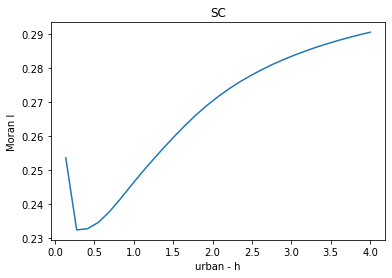

In [45]:

curr_state = all_st[11]
curr_st_key = fips_dict.get(curr_state)

sim = pd.read_csv('/Users/mercuryliu/Documents/MH Research/MH prevalence/Census tract data/Tract_to_ruca/urban_processed.csv', dtype=sim_tp)
sim = sim.loc[sim['state'] == curr_st_key]

prev =  pd.read_csv(c_path + 'ot_tract_' + curr_state + '.csv', dtype=tp)
prev_i = prev.copy()
prev_i.columns = ['state_cd', 'geoid_i', 'prev_i']
prev_m = prev.copy()
prev_m.columns = ['state_cd', 'geoid_m', 'prev_m']

sim = sim.merge(prev_i, how='inner', on='geoid_i')
sim = sim.merge(prev_m, how='left', on='geoid_m')

sim = sim.drop(columns=['state_cd_y'], axis=1)
sim = sim.fillna(0)


h_list = np.linspace(0, 4, num=30)
moran_I = []
for j in range(len(h_list)):
    moran_I.append(get_Moran_I(sim, h_list[j] ))


plt.plot(h_list, moran_I, label='urban')
plt.title(curr_state)
plt.ylabel('Moran I')
plt.xlabel('urban - h')
plt.savefig(figpath + curr_state + 'urban_h.png')

#plt.show()


<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: divide by zero encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: invalid value encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
  warnings.warn(message)
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:226: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:201: RuntimeWarning: invalid value encou

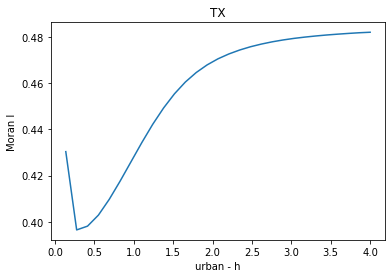

In [46]:

curr_state = all_st[12]
curr_st_key = fips_dict.get(curr_state)

sim = pd.read_csv('/Users/mercuryliu/Documents/MH Research/MH prevalence/Census tract data/Tract_to_ruca/urban_processed.csv', dtype=sim_tp)
sim = sim.loc[sim['state'] == curr_st_key]

prev =  pd.read_csv(c_path + 'ot_tract_' + curr_state + '.csv', dtype=tp)
prev_i = prev.copy()
prev_i.columns = ['state_cd', 'geoid_i', 'prev_i']
prev_m = prev.copy()
prev_m.columns = ['state_cd', 'geoid_m', 'prev_m']

sim = sim.merge(prev_i, how='inner', on='geoid_i')
sim = sim.merge(prev_m, how='left', on='geoid_m')

sim = sim.drop(columns=['state_cd_y'], axis=1)
sim = sim.fillna(0)


h_list = np.linspace(0, 4, num=30)
moran_I = []
for j in range(len(h_list)):
    moran_I.append(get_Moran_I(sim, h_list[j] ))


plt.plot(h_list, moran_I, label='urban')
plt.title(curr_state)
plt.ylabel('Moran I')
plt.xlabel('urban - h')
plt.savefig(figpath + curr_state + 'urban_h.png')

#plt.show()


<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: divide by zero encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
<ipython-input-28-66451c6ffeb9>:5: RuntimeWarning: invalid value encountered in true_divide
  neighbor_weight = np.exp(-(nb_dist) ** 2 / (2 * h ** 2)) / sum(np.exp(-(nb_dist) ** 2 / (2 * h ** 2)))
/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:226: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
/opt/anaconda3/lib/python3.8/site-packages/esda/moran.py:201: RuntimeWarning: invalid value encoun

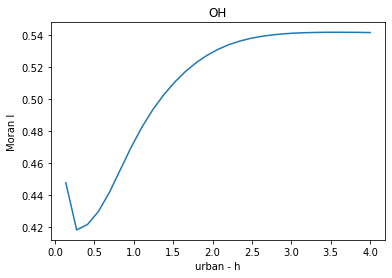

In [47]:

curr_state = all_st[13]
curr_st_key = fips_dict.get(curr_state)

sim = pd.read_csv('/Users/mercuryliu/Documents/MH Research/MH prevalence/Census tract data/Tract_to_ruca/urban_processed.csv', dtype=sim_tp)
sim = sim.loc[sim['state'] == curr_st_key]

prev =  pd.read_csv(c_path + 'ot_tract_' + curr_state + '.csv', dtype=tp)
prev_i = prev.copy()
prev_i.columns = ['state_cd', 'geoid_i', 'prev_i']
prev_m = prev.copy()
prev_m.columns = ['state_cd', 'geoid_m', 'prev_m']

sim = sim.merge(prev_i, how='inner', on='geoid_i')
sim = sim.merge(prev_m, how='left', on='geoid_m')

sim = sim.drop(columns=['state_cd_y'], axis=1)
sim = sim.fillna(0)


h_list = np.linspace(0, 4, num=30)
moran_I = []
for j in range(len(h_list)):
    moran_I.append(get_Moran_I(sim, h_list[j] ))


plt.plot(h_list, moran_I, label='urban')
plt.title(curr_state)
plt.ylabel('Moran I')
plt.xlabel('urban - h')
plt.savefig(figpath + curr_state + 'urban_h.png')

#plt.show()
